# Logistic Regression Assignment
## Lead Scoring Case Study

### Steps

0. Import required modules
1. Data import
2. Data Inspection
3. Data Cleaning and Preparation
    -Encoding Categorical Variables
    -Handling Null Values
4. EDA
    - Univariate Analysis
    - Handling Outliers
    - Data Imbalance
5. Dummy Variable Creation
6. Test-Train Split
7. Feature Scaling
8. Correlation
RESUME HERE:
9. Model Building
    - Feature Selection Using RFE
    - (Tuning) Further inspecting adjusted R-squared, VIF and p-vales
10. Build final model
11. Model evaluation with different metrics
Sensitivity, Specificity

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use("ggplot")

#### Step 1: Reading Data

In [2]:
# get the data from the csv provided
leads_data = pd.read_csv("Leads.csv")
# UI settings
pd.set_option('display.max_columns', None)
leads_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Step 2: Inspecting the Dataframe

In [3]:
# From the following, it can be seen that Lead Quality (4473) and the floowing seem to be problematic (around 50% missing)
#  30  Asymmetrique Activity Index                    5022 non-null   object 
#  31  Asymmetrique Profile Index                     5022 non-null   object 
#  32  Asymmetrique Activity Score                    5022 non-null   float64
#  33  Asymmetrique Profile Score                     5022 non-null   float64
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
# the numeric variable Total Time Spent seems to be changing steadily
# There may not be outliers for this variable
leads_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
90%,650506.100000,1.000000,7.000000,1380.000000,5.000000,16.000000,19.000000
95%,655404.050000,1.000000,10.000000,1562.000000,6.000000,17.000000,20.000000
99%,659592.980000,1.000000,17.000000,1840.610000,9.000000,17.000000,20.000000


In [5]:
# Missing Data (expressed in %)
# RELEVANT RESULTS
# Country                                          26.63
# Specialization                                   15.56
# How did you hear about X Education               23.89
# What is your current occupation                  29.11
# What matters most to you in choosing a course    29.32
# Tags                                             36.29
# Lead Quality                                     51.59
# Lead Profile                                     29.32
# City                                             15.37
# Asymmetrique Activity Index                      45.65
# Asymmetrique Profile Index                       45.65
# Asymmetrique Activity Score                      45.65
# Asymmetrique Profile Score                       45.65
round( (leads_data.isnull().sum()/leads_data.shape[0]) *100, 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

The following steps are needed to clean and prepare the data:
- Encoding categorical variables (one-hot and yes/no)
- Missing value handling (dropping and imputing as per need)
- Handling 'Select' by converting them to NaNs (as given in the problem statement)
- Dropping columns having more than a threshold for NULL values

### Step 3: Data Preparation

#### Encoding Yes/No's to 1/0s

In [6]:
# Encoding the variables with yes/no labels
yes_no_vars =  ['Do Not Email', 
                'Do Not Call',
                'Search', 
                'Magazine', 
                'Newspaper Article',
                'X Education Forums',
                'Newspaper',
                'Digital Advertisement',
                'Through Recommendations',
                'Receive More Updates About Our Courses',
                'Update me on Supply Chain Content',
                'Get updates on DM Content',
                'I agree to pay the amount through cheque',
                'A free copy of Mastering The Interview']

# defining a function for the encoding
def binary_map(x):
    return x.map({'Yes':1,'No':0})
# for var in yes_no_vars: 
#     leads_data[var] = leads_data[var].apply(lambda x : 1 if x=='Yes' else 0)
leads_data[yes_no_vars] = leads_data[yes_no_vars].apply(binary_map)
leads_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Interested in other courses,Low in Relevance,0,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Ringing,NaN,0,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,0,0,0,0,0,0,0,0,Will revert after reading the email,Might be,0,0,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Ringing,Not Sure,0,0,Select,Mumbai,02.Medium,01.High,13.0,17.0,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Will revert after reading the email,Might be,0,0,Select,Mumbai,02.Medium,01.High,15.0,18.0,0,0,Modified


**Converting SELECTs into NaNs:**

In [7]:
# Listing the categorical variables yet to be encoded
leads_data.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Prospect ID                                    9240 non-null   object
 1   Lead Origin                                    9240 non-null   object
 2   Lead Source                                    9204 non-null   object
 3   Last Activity                                  9137 non-null   object
 4   Country                                        6779 non-null   object
 5   Specialization                                 7802 non-null   object
 6   How did you hear about X Education             7033 non-null   object
 7   What is your current occupation                6550 non-null   object
 8   What matters most to you in choosing a course  6531 non-null   object
 9   Tags                                           5887 non-null   

In [8]:
# Checking the labels of the remaining categorical columns

for col in leads_data.iloc[:,1:].select_dtypes(include='object').columns:
    print(col)
    print("*"*100)
    print(leads_data[col].value_counts(normalize= True))
    print("*"*100)

Lead Origin
****************************************************************************************************
Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: Lead Origin, dtype: float64
****************************************************************************************************
Lead Source
****************************************************************************************************
Google               0.311604
Direct Traffic       0.276293
Olark Chat           0.190678
Organic Search       0.125380
Reference            0.058018
Welingak Website     0.015428
Referral Sites       0.013581
Facebook             0.005976
bing                 0.000652
google               0.000543
Click2call           0.000435
Press_Release        0.000217
Social Media         0.000217
Live Chat            0.000217
youtubechannel       0.000109
testone  

In [9]:
# Convert 'Select' to NaNs (Specialization, How did you hear about X Education, City and Lead Profile)
leads_data = leads_data.replace('Select', np.nan)

In [10]:
# Check non-nulls after replacing Select to NaNs
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   int64  
 5   Do Not Call                                    9240 non-null   int64  
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### Missing Value Handling

In [11]:
# Drop columns with more than 70% missing data
drop_thresh = 0.7
leads_data = leads_data.drop(leads_data.loc[:,list(round(leads_data.isnull().sum()/leads_data.shape[0], 2) > drop_thresh)].columns, 1)

In [12]:
# Data dictionary entry for Lead Quality:
# Indicates the quality of lead based on the data and intuition the the employee who has been assigned to the lead.
# Therefore, we replace NaNs for Lead Quality with 'not sure'

leads_data['Lead Quality'] = leads_data['Lead Quality'].replace(np.nan, 'not sure')

**Note:**
As remarked above, the columns <mark>'Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymbmetrique Profile Score'</mark> have a high % of missing data and it seems that they have some systematic errors. We decide to drop them.

In [13]:
# Checking the colums Asymmetrique X (X stands for various)
# leads_data['Asymmetrique Activity Index'].var()
# leads_data['Asymmetrique Activity Score'].var()
# leads_data['Asymmetrique Profile Index'].var()
# leads_data['Asymmetrique Profile Score'].var()
# type(leads_data['Asymmetrique Activity Index'][0])
# leads_data['Asymmetrique Activity Index'][0]

# Asymmetrique Activity Index                       object
# Asymmetrique Profile Index                        object
# Asymmetrique Activity Score                      float64
# Asymmetrique Profile Score                       float64


# not all of the types are str; need to fix this
temp1 = leads_data['Asymmetrique Activity Index'].apply(lambda x: print(type(x)) )
# same problem with this column as well: the following errors out (float object has no method split)
temp2 = leads_data['Asymmetrique Profile Index'].apply(lambda x: x.split('.')[0] )

temp2


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

AttributeError: 'float' object has no attribute 'split'

In [14]:
leads_data = leads_data.drop(['Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymmetrique Profile Score'],1)

#### Imputing Missing Values Where Possible

In [51]:
# leads_data['City'].describe()
# leads_data['City'].unique()
# leads_data['Specialization'].describe()
# leads_data['Specialization'].unique()
# leads_data['Specialization'].value_counts()
# leads_data['Specialization'].isna().sum()
# leads_data['Tags'].describe()
# leads_data['Tags'].value_counts()
# leads_data['What matters most to you in choosing a course'].value_counts(normalize=True)
# leads_data['What is your current occupation'].value_counts(normalize=True)
# leads_data['Country'].value_counts(normalize=True)

In [15]:
# As the mode is Mumbai for this column, we convert the missing values to Mumbai city
leads_data['City'] = leads_data['City'].replace(np.nan, 'Mumbai')
# There are 3380 NaNs in Specialization; we replace them by 'Other_Spec'
leads_data['Specialization'] = leads_data['Specialization'].replace(np.nan, 'Other_Spec')
# For 'Tags', the mode being 'Will revert after reading the email', we replace NaNs with this value.
leads_data['Tags'] = leads_data['Tags'].replace(np.nan, 'Will revert after reading the email')
# Better Career Prospects      0.999541 (see cell above); we replace NaNs with this value
leads_data['What matters most to you in choosing a course'] = leads_data['What matters most to you in choosing a course'].replace(np.nan, 'Better Career Prospects')
# Unemployed              0.854962 (see cell above); we replace NaNs with this value
leads_data['What is your current occupation'] = leads_data['What is your current occupation'].replace(np.nan, 'Unemployed')
# India                   0.957663; we replace NaNs with this value
leads_data['Country'] = leads_data['Country'].replace(np.nan, 'India')

In [16]:
# Missing data after the changes above (expressed as %)

round(100*(leads_data.isnull().sum()/len(leads_data.index)), 2)

Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums          

In [17]:
# Dropping the remaining NaNs as they are less than 2%
leads_data.dropna(inplace=True)
leads_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,India,Other_Spec,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Interested in other courses,Low in Relevance,0,0,Mumbai,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,India,Other_Spec,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Ringing,not sure,0,0,Mumbai,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,0,0,0,0,0,0,0,0,Will revert after reading the email,Might be,0,0,Mumbai,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Ringing,Not Sure,0,0,Mumbai,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,India,Other_Spec,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,0,Will revert after reading the email,Might be,0,0,Mumbai,0,0,Modified


### Step 4: Exploratory Data Analysis

In [18]:
# Checking for data imbalance by looking at the target variable
leads_data["Converted"].value_counts(normalize=True)

0    0.621446
1    0.378554
Name: Converted, dtype: float64

**Note:**
Data imbalance is not present and we can proceed with the analysis.

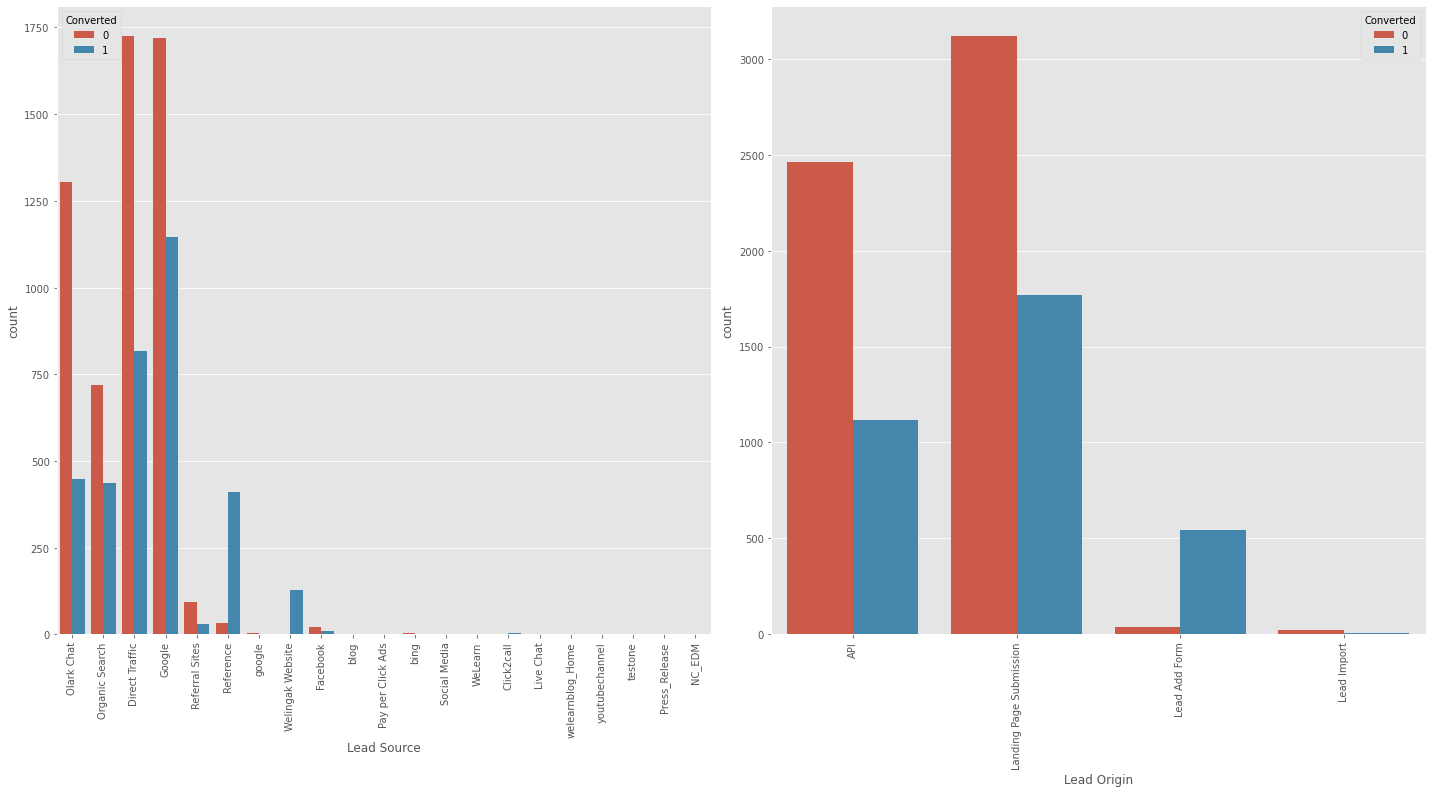

In [19]:
# plotting Lead Source and Lead Origin agains Converted
def plotting(list_vars,against='Converted',subplots=[2,2]):
    fig=plt.subplots(figsize=(20,20))
    for i, feature in enumerate(list_vars):
        plt.subplot(subplots[0], subplots[1], i+1)
        plt.subplots_adjust(hspace = 2.0)
        sns.countplot(leads_data[feature], hue=leads_data[against])
        plt.xticks(rotation=90)
        plt.tight_layout(pad=1.08)
list_vars = ['Lead Source', 'Lead Origin']
against = 'Converted'
plotting(list_vars,against,subplots=[2,2])

**Observations on the Plots:**
- Clearly, Lead Import can be ignored since it has neither lead count nor conversion rate as significant
- API and Landing Page Submission have low lead conversion but high lead count
- Lead Add Form is usable as it has high conversion

**Recommendation:**
<mark>API and Landing Page Submission are to be targeted for overall lead conversion. Also, the count Lead Add Form needs to be increased</mark>

In [20]:
# From Lead Source vs Converted plot, it's clear that various lead sources can be grouped as others

leads_data['Lead Source'] = leads_data['Lead Source'].replace(['Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
  'Social Media', 'WeLearn', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel'], 'OtherLeadSource')

leads_data['Lead Source'] = leads_data['Lead Source'].replace("google", 'Google')

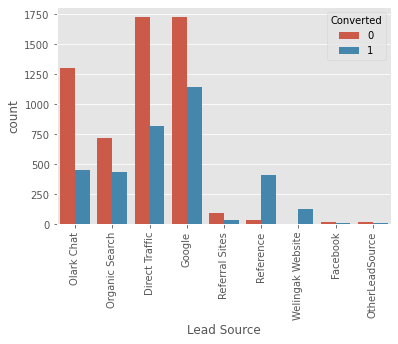

In [21]:
# Lead Source vs Converted plot 

sns.countplot(x="Lead Source", hue="Converted", data= leads_data)
plt.xticks(rotation='vertical')
plt.show()

**Observations/Recommendations on the Plot:**

The variables to focus on are Google, Direct Traffic (for lead source count) and Reference and Welingak (for conversion rate)

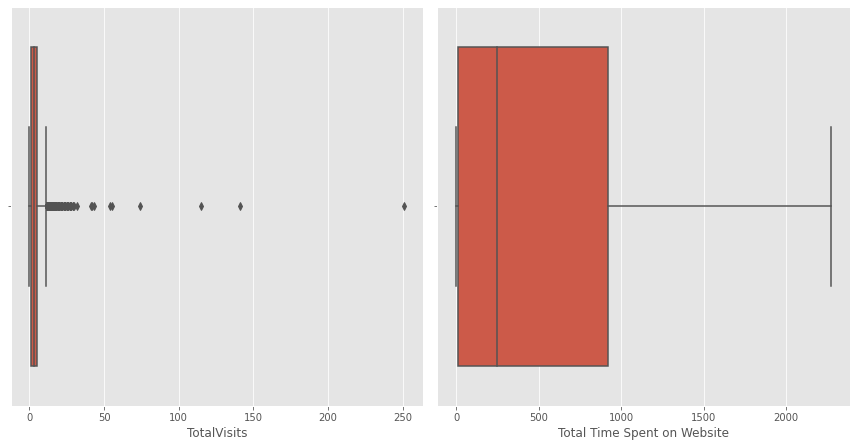

In [22]:
fig=plt.subplots(figsize=(12, 12))

list_vars = ["TotalVisits", "Total Time Spent on Website"]
for i, feature in enumerate(list_vars):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(leads_data[feature])
    plt.tight_layout()

In [23]:
# TotalVisits needs to be fixed; capping at 95% (as most common)

q1 = leads_data["TotalVisits"].quantile(0.95)
leads_data["TotalVisits"][leads_data["TotalVisits"] >= q1] = q1

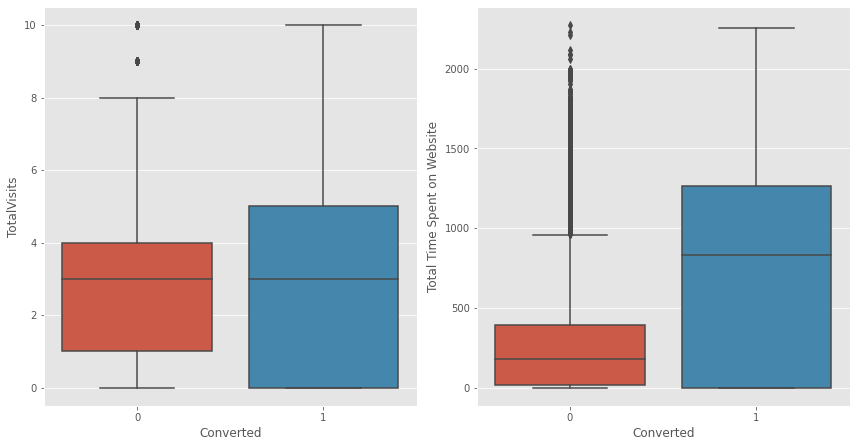

In [24]:
# Distribution of Total Visits and Total Time
fig=plt.subplots(figsize=(12, 12))

for i, feature in enumerate(["TotalVisits", "Total Time Spent on Website"]):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(y = feature, x = 'Converted', data = leads_data)
    plt.tight_layout()

**Observations/Recommendations from the Plot:**

- TotalVisits isn't insightful as the medians coincide
- Total Time Spent is a great indicator of the relation between input and conversion

**Front-end UI needs to be appealing and easy to use**

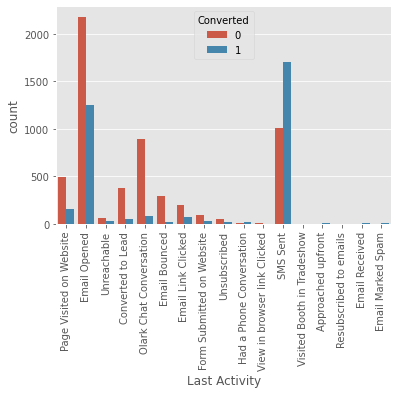

In [25]:
# replotting Last Activity to check if further dimensionality reduction possible (combining low-count columns into one 'Others')

sns.countplot(x="Last Activity", hue="Converted", data= leads_data)
plt.xticks(rotation='vertical')
plt.show()

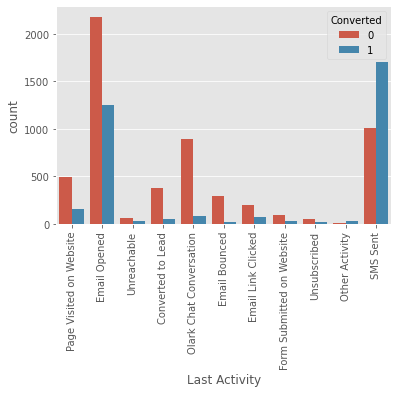

In [26]:
# Combining low-count columns to one 'Others' column
combine_these = ['Had a Phone Conversation',
                    'View in browser link Clicked',
                    'Visited Booth in Tradeshow',
                    'Approached upfront',
                    'Resubscribed to emails',
                     'Email Received',
                     'Email Marked Spam']
leads_data['Last Activity'] = leads_data['Last Activity'].replace(combine_these, 'Other Activity')

# verifying
sns.countplot(x="Last Activity", hue="Converted", data= leads_data)
plt.xticks( rotation='vertical')
plt.show()

**Observations/Recommendations from the Plot:**

- The maximum count is for Email Opened
- The maximum conversion rate is for SMS Sent

**Calling Email Opened leads will boost conversion and so will increasing the number (count) of SMS Sent leads**

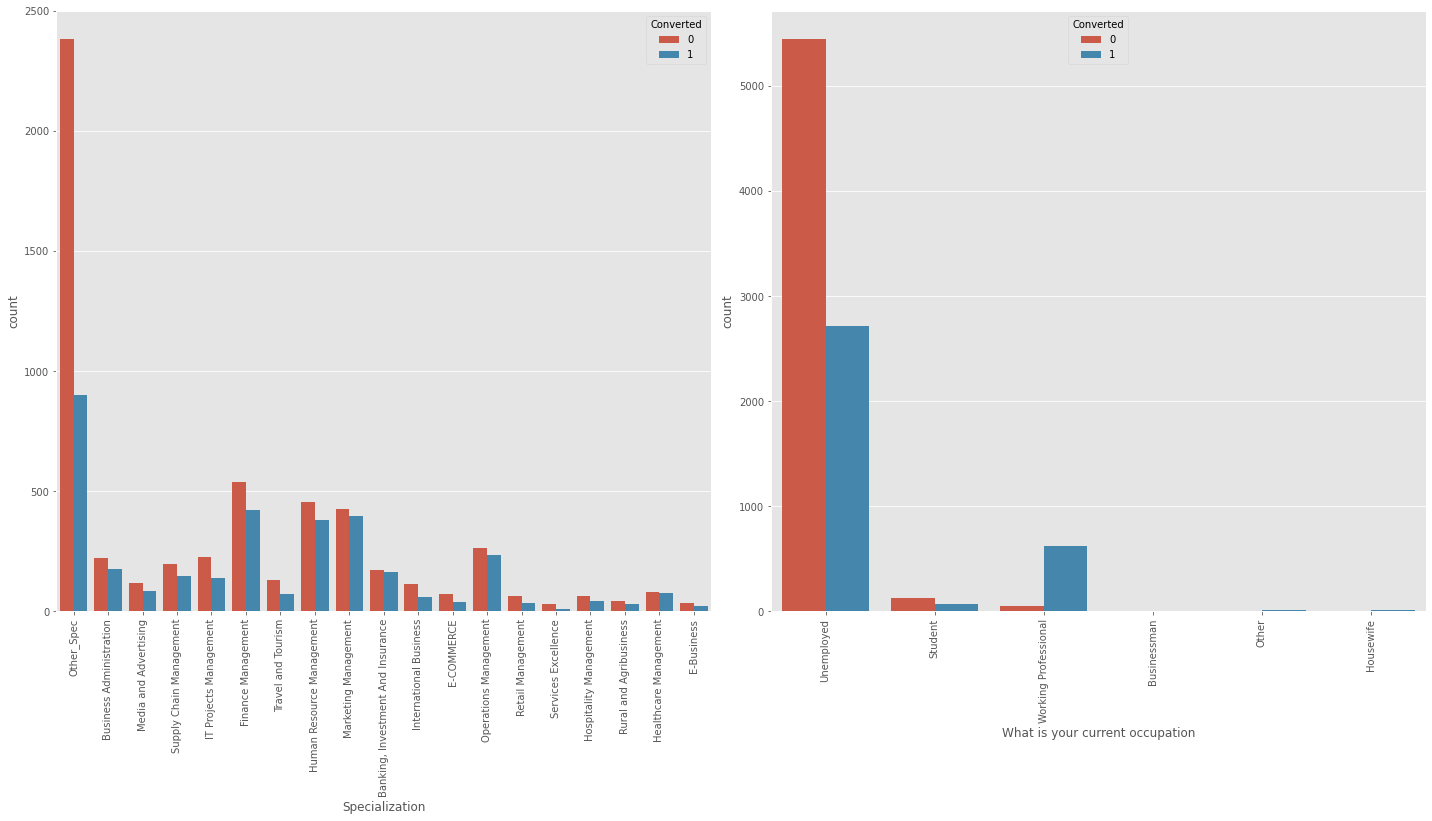

In [27]:
# plotting specialization and current occupation against conversion
list_vars = ["Specialization", "What is your current occupation"]
plotting(list_vars,subplots=[2,2])

**Observations/Recommendations from the Plot:**

- It is not possible anything substantial for Specialization
- Working professionals have a high conversion rate
- The maximum lead count is for Unemployed category

**Increase count of Working Professionals (social media, for example) and increase the conversion of Unemployed leads.**

- Country, What matters most to you in choosing a course, City columns are not insightful as the data is constant

In [28]:
# tidying up
leads_data['What is your current occupation'] = leads_data['What is your current occupation'].replace("Other", 'Other_Occupation')

In [29]:
# check if these columns provide any insights
leads_data[["Search",
                "Magazine",
                "Newspaper Article",
                "X Education Forums",
                "Newspaper",
                "Digital Advertisement",
                 "Through Recommendations",
                "Update me on Supply Chain Content",
                "Get updates on DM Content",
                "I agree to pay the amount through cheque",
                "A free copy of Mastering The Interview"]].describe()

,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
count,9074.000000,9074.0,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.0,9074.0,9074.0,9074.000000
mean,0.001543,0.0,0.000220,0.000110,0.000110,0.000441,0.000771,0.0,0.0,0.0,0.318272
std,0.039251,0.0,0.014845,0.010498,0.010498,0.020992,0.027766,0.0,0.0,0.0,0.465831
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000


**Note:**

- Most of the values being 0 (or "No"), there is nothing to infer from.

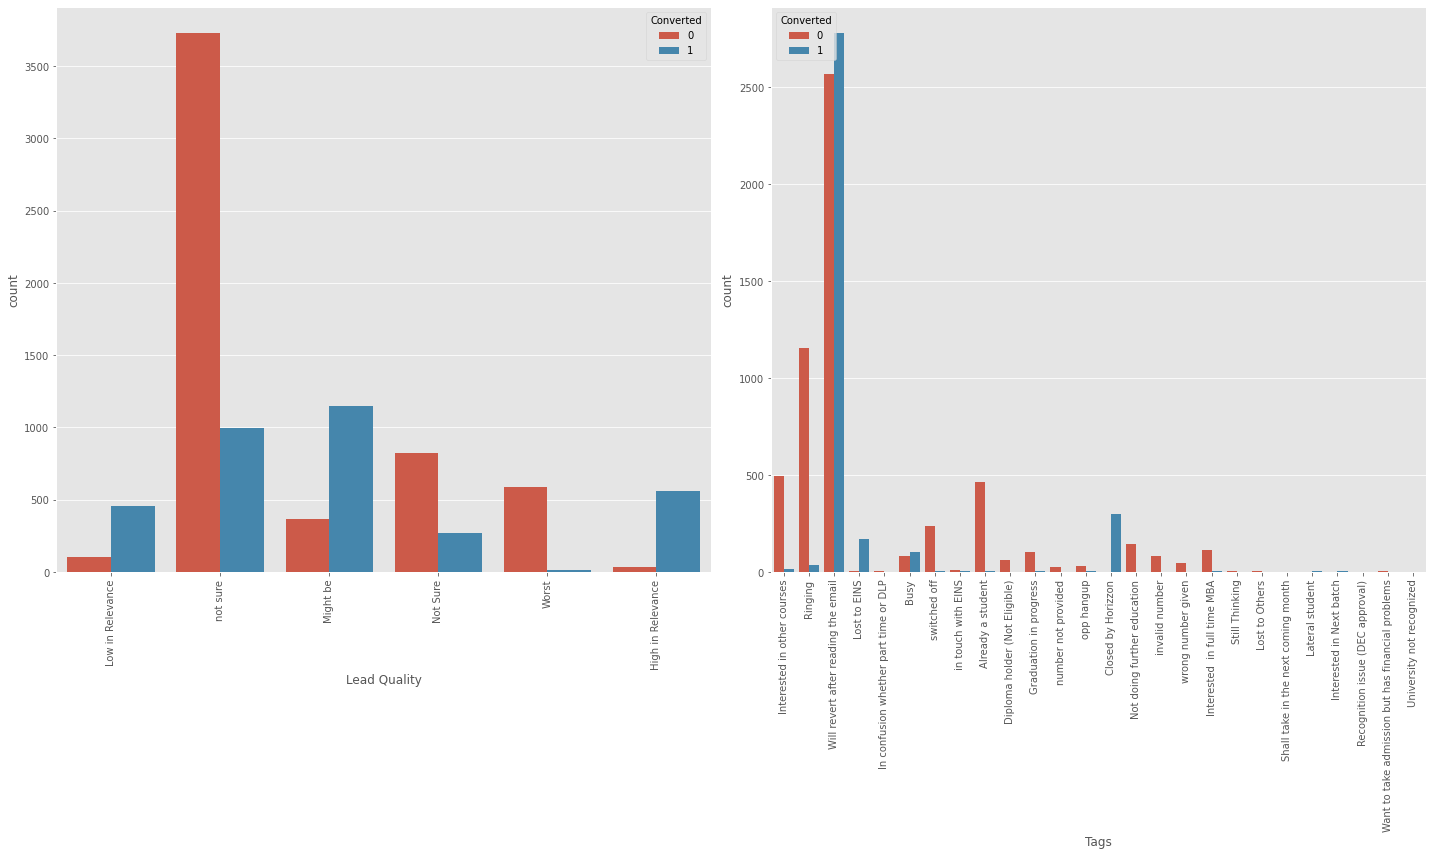

In [30]:
# plotting Lead Quality and Tags against Converted
list_vars=["Lead Quality", "Tags"]
plotting(list_vars,subplots=[2,2])

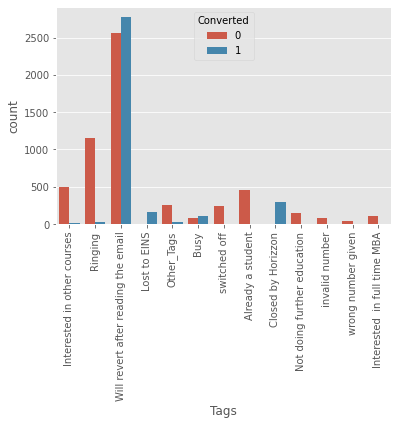

In [31]:
# Dimensionality Reduction (combining low-count features as 'Others')
combine_these = ['In confusion whether part time or DLP', 
                    'in touch with EINS',
                     'Diploma holder (Not Eligible)',
                    'Approached upfront',
                     'Graduation in progress',
                     'number not provided',
                     'opp hangup',
                     'Still Thinking',
                    'Lost to Others',
                    'Shall take in the next coming month',
                     'Lateral student',
                     'Interested in Next batch',
                    'Recognition issue (DEC approval)',
                        'Want to take admission but has financial problems',
                        'University not recognized']

leads_data['Tags'] = leads_data['Tags'].replace(combine_these, 'Other_Tags')

# verifying
sns.countplot(x="Tags", hue="Converted", data= leads_data)
plt.xticks( rotation='vertical')
plt.show()

**Summary of Recommendations from the EDA:**

- Among the features, we observe highest conversion rates for 'Will revert after reading the email' and 'Closed by Horizzon' 

##### SUMMARY:

- API and Landing Page Submission are to be targeted for overall lead conversion. Also, the count Lead Add Form needs to be increased
- The variables to focus on are Google, Direct Traffic (for lead source count) and Reference and Welingak (for conversion rate)
- Front-end UI needs to be appealing and easy to use
- Calling Email Opened leads will boost conversion and so will increasing the number (count) of SMS Sent leads
- Increase count of Working Professionals (social media, for example) and increase the conversion of Unemployed leads.

In [32]:
# Dropping columns which are unnecessary for further analysis

unnecessary_feats = ['Lead Number','What matters most to you in choosing a course','Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
           'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content',
           'Get updates on DM Content','I agree to pay the amount through cheque','A free copy of Mastering The Interview','Country','Do Not Call']
leads_data = leads_data.drop(unnecessary_feats,1)

leads_data.head()

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,City,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Other_Spec,Unemployed,Interested in other courses,Low in Relevance,Mumbai,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Other_Spec,Unemployed,Ringing,not sure,Mumbai,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Might be,Mumbai,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,Media and Advertising,Unemployed,Ringing,Not Sure,Mumbai,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Other_Spec,Unemployed,Will revert after reading the email,Might be,Mumbai,Modified


### Step 5: Dummy (one-hot) Features for categorical variables with multiple levels
for k levels, k - 1 columns needed

In [33]:
# create dummy variables/features
dummy = pd.get_dummies(leads_data[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                              'Tags','Lead Quality','City','Last Notable Activity']], drop_first=True)
dummy.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_OtherLeadSource,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Other_Spec,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other_Occupation,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Lead Quality_not sure,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [34]:
# drop the original ones
leads_data = leads_data.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization','What is your current occupation',
                              'Tags','Lead Quality','City','Last Notable Activity'], axis=1)
leads_data.head()

,Prospect ID,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,0,0,0.0,0,0.0
1,2a272436-5132-4136-86fa-dcc88c88f482,0,0,5.0,674,2.5
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0,1,2.0,1532,2.0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,0,0,1.0,305,1.0
4,3256f628-e534-4826-9d63-4a8b88782852,0,1,2.0,1428,1.0


In [35]:
# combine the dummy vars with the original df
leads_data = pd.concat([leads_data, dummy], axis=1)
leads_data.head()

,Prospect ID,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_OtherLeadSource,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Other_Spec,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other_Occupation,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Lead Quality_not sure,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,0,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,0,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0,1,2.0,1532,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,0,0,1.0,305,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,0,1,2.0,1428,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Step 6: Test-Train Split

In [36]:
# Setting feature variable to X
X = leads_data.drop(['Prospect ID','Converted'], axis=1)
# Setting response variable to y
y = leads_data['Converted']

print(y)

X.head()

0       0
1       0
2       1
3       0
4       1
       ..
9235    1
9236    0
9237    0
9238    1
9239    1
Name: Converted, Length: 9074, dtype: int64


,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_OtherLeadSource,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Other_Spec,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other_Occupation,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Lead Quality_not sure,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,2.0,1532,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1.0,305,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,2.0,1428,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [37]:
# splitting into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 7: Feature Scaling

In [38]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_OtherLeadSource,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Other Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Other_Spec,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other_Occupation,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,Lead Quality_not sure,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
3009,0,-0.432779,-0.160255,-0.179666,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1012,1,-0.432779,-0.540048,-0.179666,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9226,0,-1.150329,-0.888650,-1.132538,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4750,0,-0.432779,1.643304,-0.179666,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7987,0,0.643547,2.017593,0.058552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [39]:
### Conversion Rate?

print("Conversion rate is ", (sum(leads_data['Converted'])/len(leads_data['Converted'].index))*100)

Conversion rate is  37.85541106458012


### Step 8: Correlations

In [72]:
# Correlations for success and failures (conversion results)
leads_corr = leads_data.corr()
# The following does not help, so unstacking the matrix below
# plt.figure(figsize=(100,100))
# dataplot = sns.heatmap(leads_data.corr(), cmap="YlGnBu", annot=True)
# plt.show()


# # Get the top n correlations
n = 15
leads_corr_unstacked = leads_corr.unstack().sort_values(kind="quicksort")
# leads_corr_unstacked
t1 = leads_corr.where(np.triu(np.ones(leads_corr.shape), k=1).astype(np.bool))
t2 = t1.stack()
t3 = t2.sort_values(ascending=False)
t3.head(n)

Lead Origin_Lead Import                Lead Source_Facebook                              0.983684
Last Activity_Unsubscribed             Last Notable Activity_Unsubscribed                0.872656
Lead Origin_Lead Add Form              Lead Source_Reference                             0.866191
Last Activity_Email Opened             Last Notable Activity_Email Opened                0.861636
Last Activity_SMS Sent                 Last Notable Activity_SMS Sent                    0.853102
Last Activity_Email Link Clicked       Last Notable Activity_Email Link Clicked          0.800686
TotalVisits                            Page Views Per Visit                              0.737996
Last Activity_Page Visited on Website  Last Notable Activity_Page Visited on Website     0.691811
Do Not Email                           Last Activity_Email Bounced                       0.620041
Last Activity_Unreachable              Last Notable Activity_Unreachable                 0.594369
Last Activity_Other 

In [42]:
# Removing collinearity by dropping highly correlated features
drop_these = ['Lead Source_Facebook',
                'Last Notable Activity_Unsubscribed',
                  'Last Notable Activity_SMS Sent',
                      'Last Notable Activity_Email Opened',
                      'Last Notable Activity_Unreachable',
                      'Last Notable Activity_Email Link Clicked',
                      'Last Notable Activity_Page Visited on Website']
X_test = X_test.drop(drop_these, 1)
X_train = X_train.drop(drop_these, 1)

In [43]:
## verifying changes
leads_corr = X_train.corr()

In [44]:
leads_corr.where(np.triu(np.ones(leads_corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False).head(10)

Lead Origin_Lead Add Form     Lead Source_Reference                             0.859537
TotalVisits                   Page Views Per Visit                              0.756104
Do Not Email                  Last Activity_Email Bounced                       0.624939
Last Activity_Other Activity  Last Notable Activity_Had a Phone Conversation    0.593057
Lead Source_Olark Chat        Specialization_Other_Spec                         0.505771
Page Views Per Visit          Lead Origin_Landing Page Submission               0.493007
Lead Origin_Lead Add Form     Lead Source_Welingak Website                      0.468225
Last Activity_Email Bounced   Last Notable Activity_Email Bounced               0.450911
TotalVisits                   Lead Origin_Landing Page Submission               0.447765
Lead Source_Olark Chat        Last Activity_Olark Chat Conversation             0.419173
dtype: float64

### Step 9: Model Building

In [73]:
# Logistic regression model
# As seen from the output below, lot of features can be eliminated because they have high p-values
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6272
Model Family:                Binomial   Df Model:                           78
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1174.8
Date:                Tue, 14 Jun 2022   Deviance:                       2349.5
Time:                        16:34:04   Pearson chi2:                 1.24e+05
No. Iterations:                    24   Pseudo R-squ. (CS):             0.6183
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.0831      1.677      0.646      0.518      -2.204       4.370
Do Not Email                                            -1.3377      0.335     -3.994      0.000      -1.994      -0.681
TotalVisits                                              0.1134      0.089      1.272      0.204      -0.061       0.288
Total Time Spent on Website                              1.1347      0.065     17.348      0.000       1.007       1.263
Page Views Per Visit                                    -0.0941      0.089     -1.061      0.289      -0.268       0.080
Lead Origin_Landing Page Submission                     -1.0698      0.236     -4.526      0.000      -1.533      -0.607
Lead Origin_Lead Add Form                               -1.1305      1.735     -0.652      0.515      -4.531       2.270
Lead Origin_Lead Import                                  1.2804      0.879      1.456      0.145      -0.443       3.004
Lead Source_Google                                       0.2130      0.160      1.334      0.182      -0.100       0.526
Lead Source_Olark Chat                                   1.1293      0.238      4.741      0.000       0.662       1.596
Lead Source_Organic Search                               0.0193      0.217      0.089      0.929      -0.407       0.445
Lead Source_OtherLeadSource                              1.0408      0.866      1.202      0.229      -0.657       2.738
Lead Source_Reference                                    2.6696      1.794      1.488      0.137      -0.846       6.185
Lead Source_Referral Sites                              -0.0868      0.502     -0.173      0.863      -1.071       0.897
Lead Source_Welingak Website                             6.4979      1.892      3.435      0.001       2.790      10.205
Last Activity_Email Bounced                             -0.2242      0.893     -0.251      0.802      -1.975       1.527
Last Activity_Email Link Clicked                        -0.8532      0.491     -1.737      0.082      -1.816       0.110
Last Activity_Email Opened                              -0.2540      0.380     -0.668      0.504      -0.999       0.491
Last Activity_Form Submitted on Website                 -0.1922      0.633     -0.304      0.761      -1.433       1.048
Last Activity_Olark Chat Conversation                   -0.5250      0.426     -1.231      0.218      -1.361       0.311
Last Activity_Other Activity                             1.8410      1.221      1.508      0.131      -0.551       4.233
Last Activity_Page Visited on Website                   -0.3758      0.434     -0.866      0.387      -1.226       0.475
Last Activity_SMS Sent                                   1

### Step 10: Feature Selection Using RFE (Automated/Coarse Tuning)

In [74]:
# STAGE 1: Taking up 15 features selected by RFE
# STAGE 2: Optimization using p-values and VIF values for the features

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=15)  
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', False, 50),
 ('Total Time Spent on Website', False, 3),
 ('Page Views Per Visit', False, 51),
 ('Lead Origin_Landing Page Submission', False, 8),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 12),
 ('Lead Source_Google', False, 41),
 ('Lead Source_Olark Chat', False, 2),
 ('Lead Source_Organic Search', False, 64),
 ('Lead Source_OtherLeadSource', False, 28),
 ('Lead Source_Reference', False, 59),
 ('Lead Source_Referral Sites', False, 46),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', False, 45),
 ('Last Activity_Email Link Clicked', False, 17),
 ('Last Activity_Email Opened', False, 44),
 ('Last Activity_Form Submitted on Website', False, 52),
 ('Last Activity_Olark Chat Conversation', False, 18),
 ('Last Activity_Other Activity', False, 7),
 ('Last Activity_Page Visited on Website', False, 43),
 ('Last Activity_SMS Sent', True, 1),
 ('Last Activity_Unreachable', False, 19),
 ('L

In [77]:
col = X_train.columns[rfe.support_]

##### Assessing the model with StatsModels

In [78]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1430.4
Date:                Tue, 14 Jun 2022   Deviance:                       2860.8
Time:                        16:42:12   Pearson chi2:                 1.86e+05
No. Iterations:                    24   Pseudo R-squ. (CS):             0.5863
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.3020      0.148     -8.826      0.000      -1.591      -1.013
Do Not Email                                     -1.2291      0.233     -5.282      0.000      -1.685      -0.773
Lead Origin_Lead Add Form                         0.7361      0.418      1.759      0.079      -0.084       1.556
Lead Source_Welingak Website                      3.6047      0.846      4.259      0.000       1.946       5.263
Last Activity_SMS Sent                            2.0363      0.107     19.075      0.000       1.827       2.246
Tags_Closed by Horizzon                           9.3732      0.779     12.032      0.000       7.846      10.900
Tags_Lost to EINS                                10.1613      0.768     13.233      0.000       8.656      11.666
Tags_Ringing                                     -2.9170      0.276    -10.579      0.000      -3.457      -2.377
Tags_Will revert after reading the email          4.4197      0.200     22.085      0.000       4.027       4.812
Tags_invalid number                             -23.9006   2.15e+04     -0.001      0.999   -4.21e+04     4.2e+04
Tags_switched off                                -3.1955      0.538     -5.937      0.000      -4.250      -2.141
Tags_wrong number given                         -24.2805   3.07e+04     -0.001      0.999   -6.02e+04    6.01e+04
Lead Quality_Worst                               -3.7720      0.887     -4.250      0.000      -5.511      -2.033
Lead Quality_not sure                            -4.2200      0.157    -26.812      0.000      -4.528      -3.912
Last Notable Activity_Modified                   -1.7985      0.115    -15.632      0.000      -2.024      -1.573
Last Notable Activity_Olark Chat Conversation    -1.1843      0.367     -3.223      0.001      -1.905      -0.464
=================================================================================================================
"""

In [79]:
# Predicted values on the trained set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

3009    0.249310
1012    0.088556
9226    0.018323
4750    0.717895
7987    0.999888
1281    0.994257
2880    0.249310
4971    0.675760
7536    0.957618
1248    0.000274
dtype: float64

In [80]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([2.49309710e-01, 8.85564260e-02, 1.83228263e-02, 7.17894961e-01,
       9.99888035e-01, 9.94257250e-01, 2.49309710e-01, 6.75760277e-01,
       9.57617654e-01, 2.74268472e-04])

##### Dataframe with conversion status and predicted probabilities

In [81]:
y_train_pred_final = pd.DataFrame({'Convert':y_train.values, 'Convert_Prob':y_train_pred})
y_train_pred_final['Pros_ID'] = y_train.index
y_train_pred_final.head()

,Convert,Convert_Prob,Pros_ID
0,0,0.249310,3009
1,0,0.088556,1012
2,0,0.018323,9226
3,1,0.717895,4750
4,1,0.999888,7987


In [82]:
# Creating new column 'predicted' with 1 if Convert_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.Convert_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Convert,Convert_Prob,Pros_ID,predicted
0,0,0.249310,3009,0
1,0,0.088556,1012,0
2,0,0.018323,9226,0
3,1,0.717895,4750,1
4,1,0.999888,7987,1


In [83]:
print("Accuracy score", metrics.accuracy_score(y_train_pred_final.Convert, y_train_pred_final.predicted))

Accuracy score 0.9233191623366399


#### Checking VIFs

In [84]:
def calculate_vif(X_train):
    vif_df = pd.DataFrame()
    vif_df['Features'] = X_train.columns
    vif_df['Variance Inflation Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif_df['Variance Inflation Factor'] = round(vif_df['Variance Inflation Factor'], 2)
    vif_df = vif_df.sort_values(by = 'Variance Inflation Factor', ascending = False)
    print(vif_df)

calculate_vif(X_train[col])

                                         Features  Variance Inflation Factor
7        Tags_Will revert after reading the email                       2.76
12                          Lead Quality_not sure                       2.50
13                 Last Notable Activity_Modified                       1.62
3                          Last Activity_SMS Sent                       1.61
1                       Lead Origin_Lead Add Form                       1.57
2                    Lead Source_Welingak Website                       1.35
6                                    Tags_Ringing                       1.29
4                         Tags_Closed by Horizzon                       1.17
0                                    Do Not Email                       1.13
11                             Lead Quality_Worst                       1.12
5                               Tags_Lost to EINS                       1.05
9                               Tags_switched off                       1.05

All features have acceptable VIF values. Tags_invalid_number needs to be dropped because of its hight p-value.

In [85]:
col = col.drop('Tags_invalid number')
col

Index(['Do Not Email', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Quality_Worst',
       'Lead Quality_not sure', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [86]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1441.1
Date:                Tue, 14 Jun 2022   Deviance:                       2882.1
Time:                        16:44:04   Pearson chi2:                 1.77e+05
No. Iterations:                    22   Pseudo R-squ. (CS):             0.5849
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.4175      0.147     -9.656      0.000      -1.705      -1.130
Do Not Email                                     -1.2316      0.232     -5.320      0.000      -1.685      -0.778
Lead Origin_Lead Add Form                         0.7721      0.420      1.838      0.066      -0.051       1.596
Lead Source_Welingak Website                      3.5663      0.847      4.212      0.000       1.907       5.226
Last Activity_SMS Sent                            2.0042      0.106     18.904      0.000       1.796       2.212
Tags_Closed by Horizzon                           9.4590      0.779     12.145      0.000       7.933      10.986
Tags_Lost to EINS                                10.2566      0.768     13.357      0.000       8.752      11.762
Tags_Ringing                                     -2.7742      0.274    -10.134      0.000      -3.311      -2.238
Tags_Will revert after reading the email          4.5306      0.200     22.708      0.000       4.140       4.922
Tags_switched off                                -3.0512      0.537     -5.681      0.000      -4.104      -1.999
Tags_wrong number given                         -22.1392   1.13e+04     -0.002      0.998   -2.22e+04    2.21e+04
Lead Quality_Worst                               -3.8234      0.883     -4.329      0.000      -5.554      -2.093
Lead Quality_not sure                            -4.2089      0.157    -26.829      0.000      -4.516      -3.901
Last Notable Activity_Modified                   -1.7799      0.115    -15.511      0.000      -2.005      -1.555
Last Notable Activity_Olark Chat Conversation    -1.1862      0.367     -3.229      0.001      -1.906      -0.466
=================================================================================================================
"""

In [87]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final['Convert_Prob'] = y_train_pred

# Creating new column 'predicted' with 1 if Convert_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Convert_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Convert,Convert_Prob,Pros_ID,predicted
0,0,0.250539,3009,0
1,0,0.088880,1012,0
2,0,0.018572,9226,0
3,1,0.712691,4750,1
4,1,0.999884,7987,1


In [88]:
# Overall accuracy
print("Accuracy score", metrics.accuracy_score(y_train_pred_final.Convert, y_train_pred_final.predicted))

Accuracy score 0.9220595181861124


The accuracy is the same for all practical purposes.

##### Recheck VIF

In [89]:
calculate_vif(X_train[col])

                                         Features  Variance Inflation Factor
7        Tags_Will revert after reading the email                       2.73
11                          Lead Quality_not sure                       2.47
12                 Last Notable Activity_Modified                       1.62
3                          Last Activity_SMS Sent                       1.59
1                       Lead Origin_Lead Add Form                       1.57
2                    Lead Source_Welingak Website                       1.35
6                                    Tags_Ringing                       1.28
4                         Tags_Closed by Horizzon                       1.17
0                                    Do Not Email                       1.12
10                             Lead Quality_Worst                       1.12
5                               Tags_Lost to EINS                       1.05
8                               Tags_switched off                       1.05

**Note:**
VIF and p-values are within limits. No more variables need to be dropped and this model can be used to make predictions.

In [90]:
# function name : evaluate_model
# argumet : y_true, y_predicted
# prints Confusion matrix, accuracy, Sensitivity, Specificity, False Positive Rate, Positive Predictive Value
# returns accuracy, Sensitivity, Specificity

def evaluate_model(y_true, y_predicted, print_score=False):
    confusion = metrics.confusion_matrix(y_true, y_predicted)
    # Predicted     not_converted    converted
    # Actual
    # not_converted        TN         FP
    # converted            FN         TP

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    accuracy_sc = metrics.accuracy_score(y_true, y_predicted)
    sensitivity_score = TP / float(TP+FN)
    specificity_score = TN / float(TN+FP)
    precision_sc = precision_score(y_true, y_predicted)
    
    if print_score:
        print("Confusion Matrix :\n", confusion)
        print("Accuracy :", accuracy_sc)
        print("Sensitivity :", sensitivity_score)
        print("Specificity :", specificity_score)
        print("Precision :", precision_sc)
        
    return accuracy_sc, sensitivity_score, specificity_score, precision_sc

In [91]:
# Evaluating model
evaluate_model(y_train_pred_final.Convert, y_train_pred_final.predicted, print_score=True)

Confusion Matrix :
 [[3750  155]
 [ 340 2106]]
Accuracy : 0.9220595181861124
Sensitivity : 0.8609975470155355
Specificity : 0.9603072983354674
Precision : 0.9314462627156126


(0.9220595181861124,
 0.8609975470155355,
 0.9603072983354674,
 0.9314462627156126)

### Step 11: Plotting the ROC Curve

An ROC curve 
- shows tradeoff between sensitivity and specificity (increase in one will cause decrease in other).
- The closer the curve follows the y-axis and then the top border of the ROC space, means more area under the curve and the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space i.e. the reference line, means less area and the less accurate is the test.

Here, our goal is to have achieve good sensitivity score

In [92]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [93]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Convert, y_train_pred_final.Convert_Prob, drop_intermediate = False )

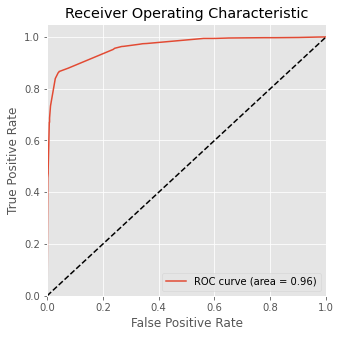

In [94]:
draw_roc(y_train_pred_final.Convert, y_train_pred_final.Convert_Prob)

### Step 12: Finding optimal value of the cut off

In [95]:
# Predicting Convert status with different probability cutoffs

for i in [float(x)/10 for x in range(10)]:
    y_train_pred_final[i]= y_train_pred_final.Convert_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Convert,Convert_Prob,Pros_ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.250539,3009,0,1,1,1,0,0,0,0,0,0,0
1,0,0.088880,1012,0,1,0,0,0,0,0,0,0,0,0
2,0,0.018572,9226,0,1,0,0,0,0,0,0,0,0,0
3,1,0.712691,4750,1,1,1,1,1,1,1,1,1,0,0
4,1,0.999884,7987,1,1,1,1,1,1,1,1,1,1,1


In [96]:
# Calculating accuracy, sensitivity and specificity for various probability cutoffs from 0.1 to 0.9.

df = pd.DataFrame(columns = ['probability_score','accuracy_score','sensitivity_score','specificity_score','precision_score'])

for i in [float(x)/10 for x in range(10)]:
    (accuracy_score,sensitivity_score,specificity_score,precision_sc) = evaluate_model(y_train_pred_final.Convert, y_train_pred_final[i])
    df.loc[i] =[i,accuracy_score,sensitivity_score,specificity_score,precision_sc]

df

,probability_score,accuracy_score,sensitivity_score,specificity_score,precision_score
0.0,0.0,0.385136,1.000000,0.000000,0.385136
0.1,0.1,0.795938,0.968929,0.687580,0.660167
0.2,0.2,0.834199,0.956255,0.757746,0.712024
0.3,0.3,0.921587,0.866721,0.955954,0.924956
0.4,0.4,0.921902,0.864677,0.957746,0.927632
0.5,0.5,0.922060,0.860998,0.960307,0.931446
0.6,0.6,0.922374,0.860998,0.960819,0.932271
0.7,0.7,0.920013,0.839330,0.970551,0.946956
0.8,0.8,0.873563,0.686018,0.991037,0.979568
0.9,0.9,0.867895,0.669665,0.992061,0.981426


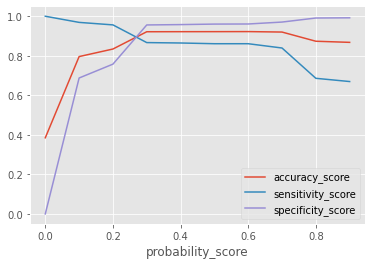

In [97]:
df.plot.line(x='probability_score', y=['accuracy_score','sensitivity_score','specificity_score'])
plt.show()

### Precision-Recall Trade off

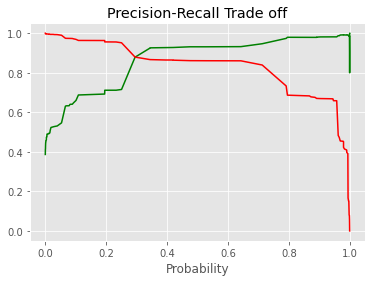

In [98]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Convert, y_train_pred_final.Convert_Prob)

plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xlabel("Probability")
plt.title("Precision-Recall Trade off")
plt.show()

**Comment:**

In Sensitivity-Specificity-Accuracy plot 0.27 probability looks optimal.
In Precision-Recall Curve 0.3 looks optimal.

We are taking 0.27 is the optimum point as a cutoff probability and assigning Lead Score in training data.

In [99]:
y_train_pred_final = y_train_pred_final.iloc[:, :3]
y_train_pred_final['Convert_predicted'] = y_train_pred_final.Convert_Prob.map(lambda x: 1 if x > 0.27 else 0)

y_train_pred_final['Lead_Score'] = y_train_pred_final.Convert_Prob.map(lambda x: round(x*100))
y_train_pred_final.head()

,Convert,Convert_Prob,Pros_ID,Convert_predicted,Lead_Score
0,0,0.250539,3009,0,25
1,0,0.088880,1012,0,9
2,0,0.018572,9226,0,2
3,1,0.712691,4750,1,71
4,1,0.999884,7987,1,100


In [100]:
# Evaluating model performance on training data

evaluate_model(y_train_pred_final.Convert, y_train_pred_final.Convert_predicted, print_score=True)

Confusion Matrix :
 [[3609  296]
 [ 295 2151]]
Accuracy : 0.9069437883797827
Sensitivity : 0.8793949304987735
Specificity : 0.9241997439180538
Precision : 0.8790355537392726


(0.9069437883797827,
 0.8793949304987735,
 0.9241997439180538,
 0.8790355537392726)

In [101]:
# Getting the predicted values on the train set
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = res.predict(X_test_sm)

y_test_df = pd.DataFrame(y_test)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["Converting_Probability"])
y_test_df['Prospect ID'] = y_test_df.index

y_predicted_final = pd.concat([y_test_df.reset_index(drop=True), y_test_pred_df.reset_index(drop=True)],axis=1)
y_predicted_final['final_predicted'] = y_predicted_final.Converting_Probability.map(lambda x: 1 if x > 0.27 else 0)
y_predicted_final['Lead_Score'] = y_predicted_final.Converting_Probability.map(lambda x: round(x*100))

y_predicted_final.head()

,Converted,Prospect ID,Converting_Probability,final_predicted,Lead_Score
0,0,3271,0.250539,0,25
1,1,1490,0.957431,1,96
2,0,7936,0.250539,0,25
3,1,4216,0.999119,1,100
4,0,3830,0.250539,0,25


In [102]:
# Evaluating model performance on test data

evaluate_model(y_predicted_final.Converted, y_predicted_final.final_predicted, print_score=True)

Confusion Matrix :
 [[1599  135]
 [ 141  848]]
Accuracy : 0.8986412045538009
Sensitivity : 0.8574317492416582
Specificity : 0.9221453287197232
Precision : 0.8626653102746694


(0.8986412045538009,
 0.8574317492416582,
 0.9221453287197232,
 0.8626653102746694)

### Step 12 : Final Model

In [110]:
# Builds a logistic regression model and returns predicted values on training dataset
# when training data, test data and probability cutoff is given

def build_model_cutoff(X_train, y_train, X_test, y_test, cutoff=0.5):
    
    # Train model
    X_train_sm = sm.add_constant(X_train)
    logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
    res = logm.fit()

    y_train_pred = res.predict(X_train_sm).values.reshape(-1)
    
    y_train_pred_final = pd.DataFrame({'Prospect ID':y_train.index, 'Converted':y_train.values, 'Convert_Probability':y_train_pred})
    y_train_pred_final['Convert_predicted'] = y_train_pred_final.Convert_Probability.map(lambda x: 1 if x > cutoff else 0)
    y_train_pred_final['Lead_Score'] = y_train_pred_final.Convert_Probability.map(lambda x: round(x*100))
    print("Result of training data")
    print(y_train_pred_final.head())
    
    # Predicting Lead Score on Test data
    X_test_sm = sm.add_constant(X_test)
    y_test_pred = res.predict(X_test_sm)

    y_test_pred_final = pd.DataFrame({'Prospect ID':y_test.index, 'Converted':y_test.values, 'Convert_Probability':y_test_pred})
    y_test_pred_final['Convert_predicted'] = y_test_pred_final.Convert_Probability.map(lambda x: 1 if x > cutoff else 0)
    y_test_pred_final['Lead_Score'] = y_test_pred_final.Convert_Probability.map(lambda x: round(x*100))
    y_test_pred_final.reset_index(inplace=True, drop=True)
    print("Result of test data")
    print(y_test_pred_final.head())
    
    print("Model Evaluation Metrics")
    evaluate_model(y_test_pred_final.Converted, y_test_pred_final.Convert_predicted, print_score=True)
    
    return y_test_pred_final

In [111]:
build_model_cutoff(X_train[col], y_train, X_test[col], y_test, cutoff=0.27)

Result of training data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3009          0             0.250539                  0          25
1         1012          0             0.088880                  0           9
2         9226          0             0.018572                  0           2
3         4750          1             0.712691                  1          71
4         7987          1             0.999884                  1         100
Result of test data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3271          0             0.250539                  0          25
1         1490          1             0.957431                  1          96
2         7936          0             0.250539                  0          25
3         4216          1             0.999119                  1         100
4         3830          0             0.250539                  0          25
Model Evaluation Met

,Prospect ID,Converted,Convert_Probability,Convert_predicted,Lead_Score
0,3271,0,0.250539,0,25
1,1490,1,0.957431,1,96
2,7936,0,0.250539,0,25
3,4216,1,0.999119,1,100
4,3830,0,0.250539,0,25
...,...,...,...,...,...
2718,850,0,0.053371,0,5
2719,2879,0,0.000607,0,0
2720,6501,1,0.994044,1,99
2721,7155,0,0.053371,0,5


In [105]:
print("Features used in Final Model :", col)

print("-----------------------Feature Importance--------------------")
print(res.params)

Features used in Final Model : Index(['Do Not Email', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Quality_Worst',
       'Lead Quality_not sure', 'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')
-----------------------Feature Importance--------------------
const                                            -1.417505
Do Not Email                                     -1.231649
Lead Origin_Lead Add Form                         0.772098
Lead Source_Welingak Website                      3.566322
Last Activity_SMS Sent                            2.004227
Tags_Closed by Horizzon                           9.459012
Tags_Lost to EINS                                10.256576
Tags_Ringing                     

### Subjective Question
3.	X Education has a period of 2 months every year during which they hire some interns. The sales team, in particular, has around 10 interns allotted to them. So during this phase, they wish to make the lead conversion more aggressive. So they want almost all of the potential leads (i.e. the customers who have been predicted as 1 by the model) to be converted and hence, want to make phone calls to as much of such people as possible. Suggest a good strategy they should employ at this stage.


In [112]:
build_model_cutoff(X_train[col], y_train, X_test[col], y_test, cutoff=0.1)

Result of training data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3009          0             0.250539                  1          25
1         1012          0             0.088880                  0           9
2         9226          0             0.018572                  0           2
3         4750          1             0.712691                  1          71
4         7987          1             0.999884                  1         100
Result of test data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3271          0             0.250539                  1          25
1         1490          1             0.957431                  1          96
2         7936          0             0.250539                  1          25
3         4216          1             0.999119                  1         100
4         3830          0             0.250539                  1          25
Model Evaluation Met

,Prospect ID,Converted,Convert_Probability,Convert_predicted,Lead_Score
0,3271,0,0.250539,1,25
1,1490,1,0.957431,1,96
2,7936,0,0.250539,1,25
3,4216,1,0.999119,1,100
4,3830,0,0.250539,1,25
...,...,...,...,...,...
2718,850,0,0.053371,0,5
2719,2879,0,0.000607,0,0
2720,6501,1,0.994044,1,99
2721,7155,0,0.053371,0,5


### Subjective Question
4.	Similarly, at times, the company reaches its target for a quarter before the deadline. During this time, the company wants the sales team to focus on some new work as well. So during this time, the company’s aim is to not make phone calls unless it’s extremely necessary, i.e. they want to minimize the rate of useless phone calls. Suggest a strategy they should employ at this stage.

In [113]:
build_model_cutoff(X_train[col], y_train, X_test[col], y_test, cutoff=0.9)

Result of training data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3009          0             0.250539                  0          25
1         1012          0             0.088880                  0           9
2         9226          0             0.018572                  0           2
3         4750          1             0.712691                  0          71
4         7987          1             0.999884                  1         100
Result of test data
   Prospect ID  Converted  Convert_Probability  Convert_predicted  Lead_Score
0         3271          0             0.250539                  0          25
1         1490          1             0.957431                  1          96
2         7936          0             0.250539                  0          25
3         4216          1             0.999119                  1         100
4         3830          0             0.250539                  0          25
Model Evaluation Met

,Prospect ID,Converted,Convert_Probability,Convert_predicted,Lead_Score
0,3271,0,0.250539,0,25
1,1490,1,0.957431,1,96
2,7936,0,0.250539,0,25
3,4216,1,0.999119,1,100
4,3830,0,0.250539,0,25
...,...,...,...,...,...
2718,850,0,0.053371,0,5
2719,2879,0,0.000607,0,0
2720,6501,1,0.994044,1,99
2721,7155,0,0.053371,0,5
